### Project Goal

To explore the sales of the super store over time and make a prediction for the next 10 months using SARIMA model


## A. Data Preprocessing


#### A.1 Importing Libraries


In [68]:
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error


import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#### A.2 Importing Dataset


In [69]:
df = pd.read_csv("train.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


**# Dataset Information**

**Source:** Kaggle: [https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/data](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting/data)

**Target Variable:** Sales

**Time Feature:** Order Date

**Potential Factors Influencing Sales:**

- Type of products
- Location of customers

**Features to Consider for Removal:**

- Row ID
- Customer Name
- Postal Code

**Actions:**

1. **Convert datetime features:**

   - Ensure appropriate handling of the 'Order Date' feature for time-based analysis.

2. **Explore potential factors:**

   - Investigate the relationship between product types and sales.
   - Analyze the impact of customer location on sales.

3. **Evaluate feature importance:**
   - Determine the relevance of features like 'Row ID', 'Customer Name', and 'Postal Code' to the analysis and consider their removal if deemed insignificant.


In [70]:
# Drop features that are not needed
df.drop(['Row ID', 'Customer Name', 'Postal Code'], axis=1, inplace=True)

In [71]:
# Convert time features
time_feats = ["Order Date", "Ship Date"]

for col in time_feats:
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)

In [72]:
df.drop_duplicates(inplace=True)
df.head()


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,2017-12-06,2017-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


#### A.3 Explonaotry Data Analysis (EDA)


In [157]:
data = df.copy()
geo_feats = ["State", "City"]

for i in geo_feats:
    dfcopy = data.groupby(i).sum().sort_values("Sales", ascending=False).head(10)
    dfcopy.reset_index(inplace=True)
    
    fig=px.bar(dfcopy, x=i, y='Sales',title="Top 10 "+i,color_discrete_sequence=px.colors.qualitative.Plotly)
    fig.show()

In [135]:
cat_feats = ["Ship Mode", "Segment", "Category", "Sub-Category"]

for i in cat_feats:
    fig = px.pie(data, values='Sales', names=i)
    fig.show()

#### A4. EDA Conclusions

- Most sales are significantly generated from California and New York states, correspondings to Los Angeles city and New York city.
- The main customers are individual customer, products are shipped with standard class.
- Sales are equally divided amongst 3 categories: technology, furniture, and office supplies


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9799 entries, 0 to 9799
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      9799 non-null   object        
 1   Order Date    9799 non-null   datetime64[ns]
 2   Ship Date     9799 non-null   datetime64[ns]
 3   Ship Mode     9799 non-null   object        
 4   Customer ID   9799 non-null   object        
 5   Segment       9799 non-null   object        
 6   Country       9799 non-null   object        
 7   City          9799 non-null   object        
 8   State         9799 non-null   object        
 9   Region        9799 non-null   object        
 10  Product ID    9799 non-null   object        
 11  Category      9799 non-null   object        
 12  Sub-Category  9799 non-null   object        
 13  Product Name  9799 non-null   object        
 14  Sales         9799 non-null   float64       
dtypes: datetime64[ns](2), float64(1), obje

In [76]:
df['Order Date'].sort_values().head(20)

540    2015-01-02
5713   2015-01-03
8309   2015-01-03
6548   2015-01-03
7949   2015-01-03
6547   2015-01-03
157    2015-01-03
7947   2015-01-03
8310   2015-01-03
7948   2015-01-03
7950   2015-01-03
1372   2015-01-04
1373   2015-01-04
7954   2015-01-04
7953   2015-01-04
307    2015-01-06
244    2015-01-06
245    2015-01-06
247    2015-01-06
248    2015-01-06
Name: Order Date, dtype: datetime64[ns]

Insights

- there are skipped dates in the dataset, which means there are no sales on those dates
- thus, we need to fill in the missing dates


In [77]:
index = pd.date_range(min(df["Order Date"]), max(df["Order Date"]))
print(index)


DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', length=1459, freq='D')


In [78]:
new_time = pd.DataFrame({"Order Date":index})
# Merge with the clean dataset
df = pd.merge(new_time, data, on="Order Date", how='left')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10028 entries, 0 to 10027
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    10028 non-null  datetime64[ns]
 1   Order ID      9799 non-null   object        
 2   Ship Date     9799 non-null   datetime64[ns]
 3   Ship Mode     9799 non-null   object        
 4   Customer ID   9799 non-null   object        
 5   Segment       9799 non-null   object        
 6   Country       9799 non-null   object        
 7   City          9799 non-null   object        
 8   State         9799 non-null   object        
 9   Region        9799 non-null   object        
 10  Product ID    9799 non-null   object        
 11  Category      9799 non-null   object        
 12  Sub-Category  9799 non-null   object        
 13  Product Name  9799 non-null   object        
 14  Sales         9799 non-null   float64       
dtypes: datetime64[ns](2), float64(1), ob

**# note**

- The original dataset has 9799 entries
- The new one has 10028 entries, including skipped days where sales is 0


#### A5. Data Preparation


In [79]:
data.head(20)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,2017-12-06,2017-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
5,CA-2015-115812,2015-09-06,2015-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600
6,CA-2015-115812,2015-09-06,2015-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800
7,CA-2015-115812,2015-09-06,2015-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520
8,CA-2015-115812,2015-09-06,2015-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040
9,CA-2015-115812,2015-09-06,2015-06-14,Standard Class,BH-11710,Consumer,United States,Los Angeles,California,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000


In [80]:
# Aggregate all daily revenue
time_sales = df.groupby("Order Date").sum()
time_sales

,Sales
Order Date,
2015-01-02,468.9000
2015-01-03,2203.1510
2015-01-04,119.8880
2015-01-05,0.0000
2015-01-06,5188.5200
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


In [81]:
# reset the index for graphing purpose
time_sales1 = time_sales.copy()
time_sales1.reset_index(inplace=True)

In [82]:
# Resample the data on 'Sales' price weekly
sale_weekly = time_sales1.resample('W', on='Order Date').mean()

# Resample the data on 'Sales' price monthly
sale_monthly = time_sales1.resample('M', on='Order Date').mean()

# Resample the data on 'Sales' price annualy
sale_annualy = time_sales1.resample('A', on='Order Date').mean()


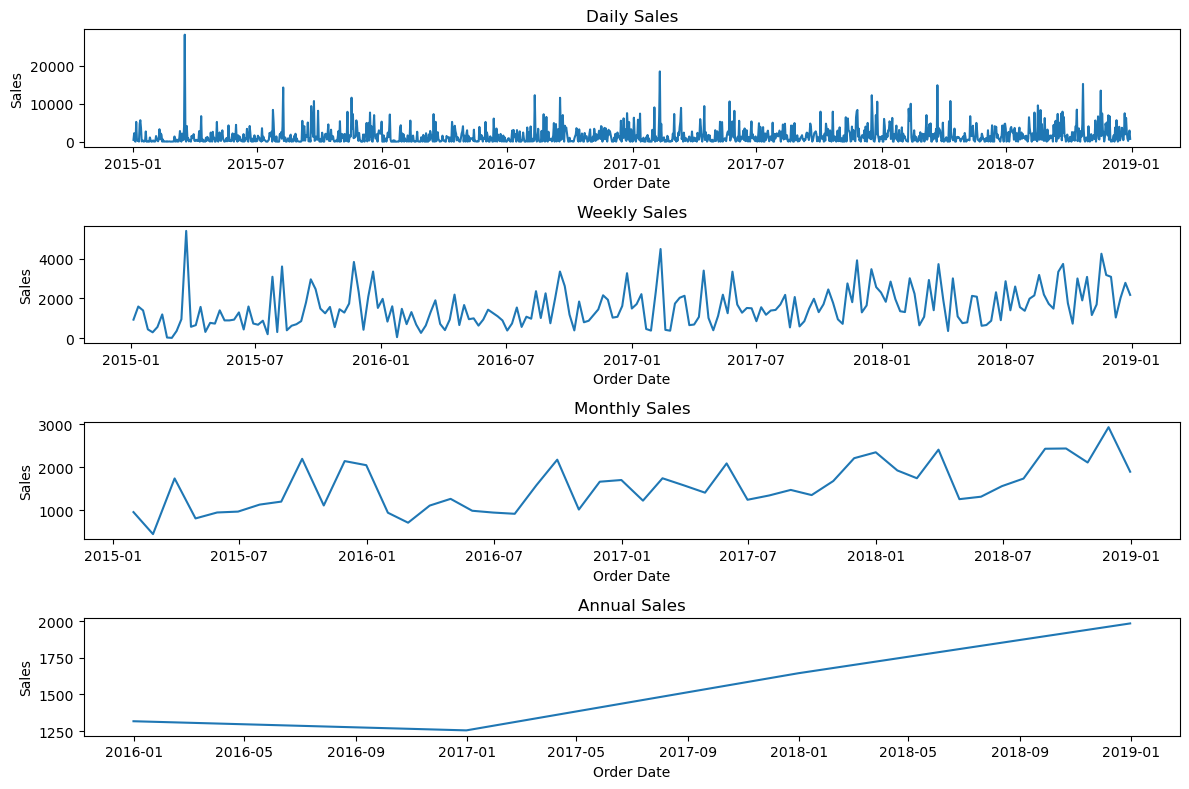

In [83]:
# Visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,8))

sns.lineplot(x='Order Date', y='Sales', data=time_sales1, ax=ax1)
ax1.set_title('Daily Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_weekly, ax=ax2)
ax2.set_title('Weekly Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_monthly, ax=ax3)
ax3.set_title('Monthly Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_annualy, ax=ax4)
ax4.set_title('Annual Sales')

plt.tight_layout()

#### A6. Seasonal Decomposition


Figure(640x480)


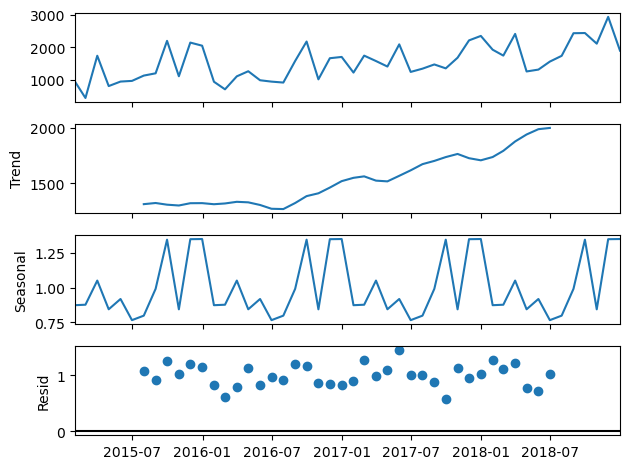

In [85]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(sale_monthly, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
print(decomposition.plot())

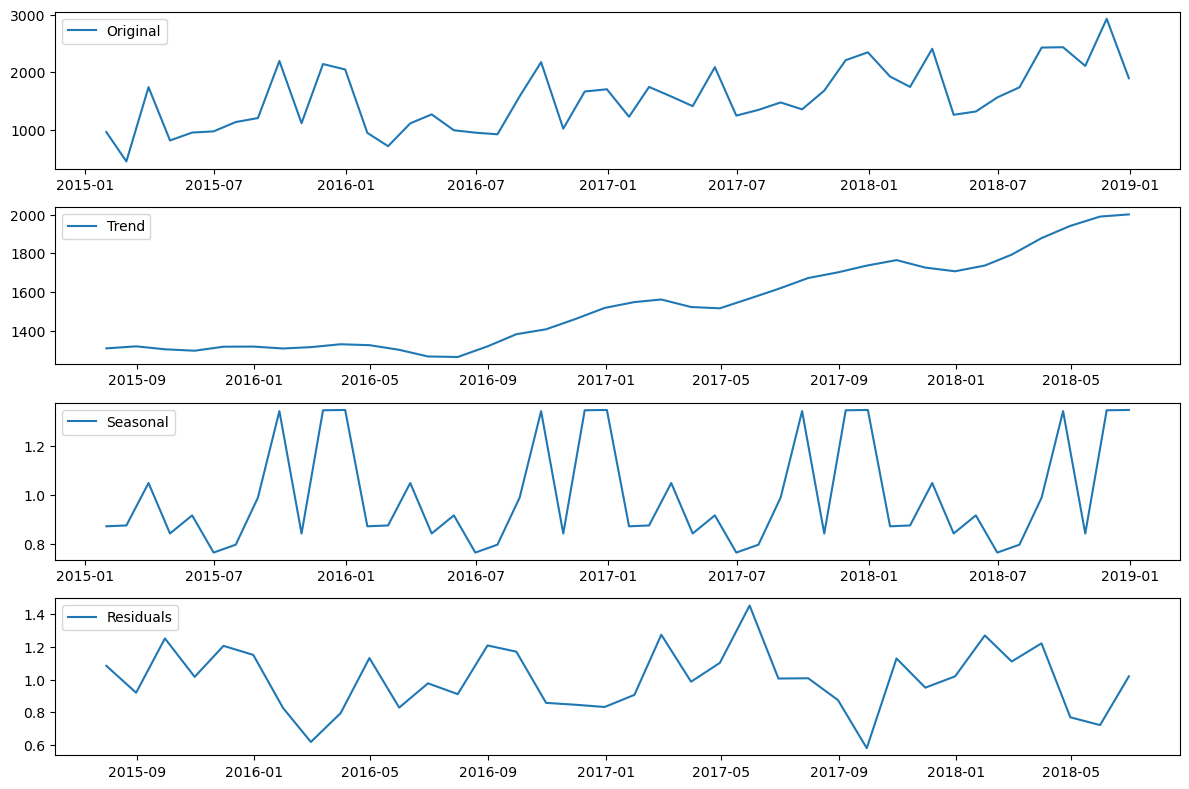

In [86]:
# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sale_monthly, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

#### A7. Split Train-Test Sets


In [87]:
# train-set size
size = 0.8 
# split the dataset
train, test = sale_monthly.iloc[:int(size*len(sale_monthly))], sale_monthly.iloc[int(size*len(sale_monthly)):]

# 80% of data for training and 20% for testing

## B. Stationary Test


- **Null Hypothesis (Ho):** The time series is non-stationary.
- **Alternate Hypothesis (Ha):** The time series is stationary.


In [90]:
#  stationary test using Augmented Dickey-Fuller Test
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    print("ADF Test Result:")
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    print('\n')
    if adf_statistic < critical_values["5%"] and p_value < 0.05:
        print('The time series is likely stationary (i.e. Reject the Null Hypothesis)')
    else:
        print('The time series is likely non-stationary (i.e. Do not reject the Null Hypothesis)')

In [89]:
test_stationarity(train["Sales"])

ADF Test Result:
ADF Statistic: -4.516504957882658
p-value: 0.0001835687703633567
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}


The time series is likely stationary (i.e. Reject the Null Hypothesis)


## C. Identify Parameters


Use the auto_arima function to identify the parameters


In [91]:
model_param = auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=580.132, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=571.622, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=578.181, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=572.711, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=573.535, Time=0.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=573.516, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=572.063, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=578.413, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=570.204, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=569.842, Time=0.08 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=570.648, Time=0.06 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=57

## D. Build Sarima Model


In [92]:
order = (0, 1, 1)  # (p, d, q)
seasonal_order = (1, 0, 0, 12)  # (P, D, Q, s)

#### D.1 Train the Model


In [94]:
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
train_model = model.fit()
train_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   38
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -278.510
Date:                             Sun, 28 Jan 2024   AIC                            563.020
Time:                                     12:23:16   BIC                            567.852
Sample:                                 01-31-2015   HQIC                           564.723
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8442      0.092     -9.176      0.000      -1.025      -0.664
ar.S.L12       0.4206      0.157      2.680      0.007       0.113       0.728
sigma2      1.798e+05    4.9e+04      3.667      0.000    8.37e+04    2.76e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.81   Prob(JB):                         0.30
Heteroskedasticity (H):               0.55   Skew:                             0.51
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### D.2 Predict the Test Set


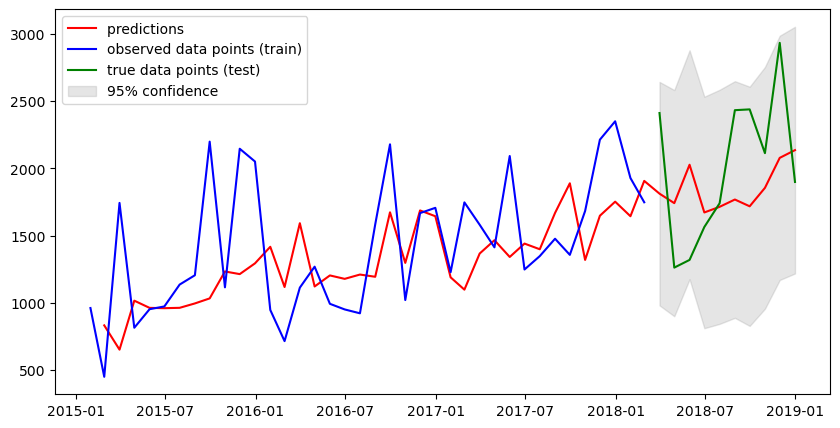

In [129]:
# Making prediction on test set 

pred = train_model.get_prediction(start='2015-01-31', end='2018-12-31')
pred_ci = pred.conf_int() # confidence interval
test_CI = pred_ci.loc[test.index[0]:] # confidence interval for test set

# plot the prediction 
plt.figure(figsize=(10,5))
plt.plot(pred.predicted_mean[1:],color='red',label='predictions ')
plt.plot(train,color='blue',label='observed data points (train)')
plt.plot(test,color='green',label='true data points (test)')
plt.fill_between(test_CI.index, test_CI.iloc[:,0], test_CI.iloc[:,1], color='gray', alpha=.2, label='95% confidence')
plt.legend()
plt.show()

Notes

- Train set: 2015-01-31 to 2018-02-28
- Test set: 2018-03-31 to 2018-12-31



#### D.3 Evaluate the Model

In [131]:
# Calculate the Forecast Error: expected - predicted
forecast_error = sale_monthly['Sales'][1:] - pred.predicted_mean[1:]

# Mean forecast error
mean_forecast_error = np.mean(forecast_error)
print(f"Mean Absolute Error: {mean_absolute_error(sale_monthly,pred.predicted_mean)}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(sale_monthly,pred.predicted_mean)}")

Mean Absolute Error: 391.5608208877145
Mean Absolute Percentage Error: 0.26361165634242184


Insights

- The MAPE is 0.26% which is very low, indicating that the model is very accurate in predicting the test set.
- Positive MFE: Indicates this model is under forecasting.


## E. Apply the Model on the full dataset


#### E.1 Train the Model on sales_monthly dataset

In [134]:
full_model = SARIMAX(sale_monthly, order=order, seasonal_order=seasonal_order)
results = full_model.fit()

##### E2. Make prediction on the monthly_sale

In [136]:
new_pred = results.get_prediction(start='2015-01-31', end='2018-12-31')

## F. Forecasting for the next 10 months


In [156]:
forecast_periods = 10 # Number of future periods to forecast: 10 months
forecast = results.get_forecast(steps=forecast_periods)

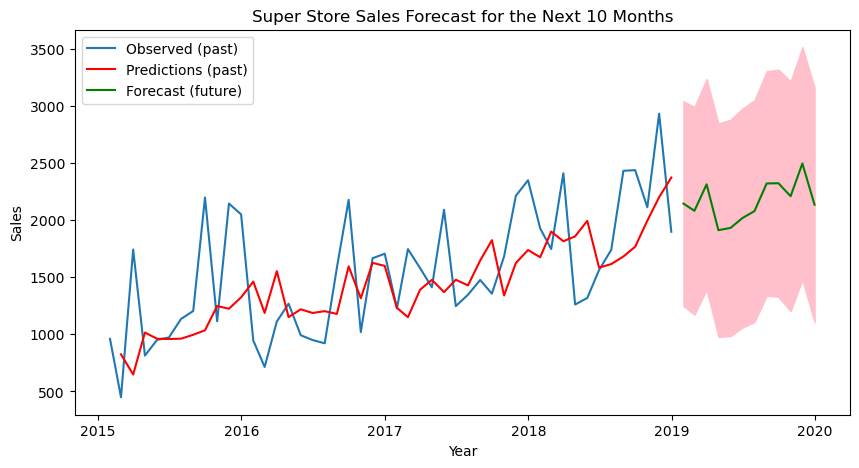

In [152]:
# Plot original data and forecast
plt.figure(figsize=(10, 5))
plt.plot(sale_monthly, label='Observed (past)')
plt.plot(new_pred.predicted_mean[1:], color='red', label='Predictions (past)')
plt.plot(forecast.predicted_mean, color='green', label='Forecast (future)')
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Sales'], forecast.conf_int()['upper Sales'], color='pink')

plt.title("Super Store Sales Forecast for the Next 10 Months")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(loc='upper left')
plt.show()

In [153]:
# plot using plotly
fig = px.line(sale_monthly, x=sale_monthly.index, y='Sales', title='Super Store Sales Forecast for the Next 10 Months')
fig.add_scatter(x=forecast.predicted_mean.index, y=forecast.predicted_mean, name='Forecast')
fig.add_scatter(x=new_pred.predicted_mean.index, y=new_pred.predicted_mean, name='Predictions')
fig.show()

## G. Conclusion



## Dataset Insights

- The original dataset exhibits a **seasonal pattern**, with sales surging during the **July-September** and **November-December** periods.
- There seems to be a year-over-year **increase** in the store's sales revenue.

## Forecasting with the SARIMA Model

- As previously mentioned, the model, which was constructed using the **SARIMA method**, appears to be **under forecasting** at the moment.
- The model's revenue predictions are more **conservative** compared to the actual sales, which exhibit significant fluctuations.
- The model is expected to continue this forecasting trend for the **upcoming 10 months**.